In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import linregress 
import numpy as np
import math
import matplotlib.ticker as ticker

In [86]:
folder_path='../data'
sensorsID=['0.0','0.1','0.2','0.3','1.0','1.1','1.2','1.3','2.0','2.1','2.2','2.3','3.0','3.1','3.2','3.3', '4.0','4.1','4.2','4.3']
wavelength='532'#'532' #1064
outputpath =  f'{folder_path}/plotsADCthr'
i='1'
datasets= '1'

slopes = []
intercepts= []
rCoes = []
stderr = []
intercepts_stderr = []

if wavelength == '532':
# Rename DataFrame columns
    strg_L = 'Laser Current (mA)'
    temp = '20'
elif wavelength == '1064':
    strg_L = 'Laser Power (mW)'
    temp = '25'

ADCthreshold=4000 #the ADC saturates
    
for l in sensorsID:
    sensorID=l
    #print(sensorID)
    filename = f'{folder_path}/test23052024_{sensorID}_{wavelength}_{i}.txt'
    T = pd.read_csv(filename,delimiter ='\t',header=None)
    T.columns = ['Date-Hour', 'L', 'TotalSum', 'TotalSquareSum', 'meanRefPD', 'stdRefPD', 'Tem', 'RH', 'TotalCounts']
    #T.columns = ['Date-Hour', 'L', 'meanPM', 'stdPM', 'meanRefPD', 'stdRefPD', 'Tem', 'RH', 'TotalCounts']

    meanADC=T['TotalSum']/T['TotalCounts']
    stdADC=np.sqrt((T['TotalSquareSum']-T['TotalCounts']*meanADC**2)/(T['TotalCounts']-1))
    
    #Monica proposed from the baffle paper: 
    #Voltage/ADCcount =3.3V/2**10=0.00322 V/ADCcount
    #4.6 uW/ADCcount*1ADCcount/0.00322V = 1428 uW/V
    #Otger says 0.61mV/ADCcount

    meanPM=meanADC*0.61e-3 #0.61mV/ADCcount   #this conversion should be done in W not in V might check this one
    stdPM=stdADC*0.61e-3

    #meanPM=4.6e-6*meanADC/0.61e-3 #0.61mV/ADCcount   #this conversion might be incorrect
    #stdPM=stdADC*4.6e-6/0.61e-3

    T['meanADC']=meanADC
    T['stdADC']=stdADC

    T['meanPM']=meanPM
    T['stdPM']=stdPM
    #Tpedestal=T.head(1).copy()
    Tpedestal=T[(T['L']== 0)]
    #Tpedestalid=T[(T['L']== 0)].index
    # Remove the rows from T that corresponds to the pedestal
    T = T.drop(T[(T['L']== 0)].index)
    
    Tsaturated=T[(T['meanADC']> ADCthreshold)]
    T = T.drop(T[(T['meanADC']> ADCthreshold)].index)

    res = linregress(T['meanRefPD'], T['meanADC'])
    slope = res.slope 
    intercept = res.intercept
    r=res.rvalue
    se = res.stderr
    intercept_stderr = res.intercept_stderr

    slopes.append(slope)
    intercepts.append(intercept)
    rCoes.append(r)
    stderr.append(se)
    intercepts_stderr.append(intercept_stderr)

    
    #this one is not correct
    '''
    resPM = linregress(T['meanRefPD'], T['meanPM'])
    slopePM = resPM.slope 
    interceptPM = resPM.intercept
    rPM=resPM.rvalue
    sePM = resPM.stderr
    intercept_stderrPM = resPM.intercept_stderr
    '''


    print(f'Calibration coefficient found for sensorID {sensorID} for laser {wavelength} nm = {res.slope} +/- {res.stderr} in ADC/V')

    fig = plt.figure(1)
    plt.errorbar(T['L'], T['TotalSum'], yerr=T['stdADC'], fmt='.', markersize=10, linewidth=1)
    plt.ylabel('Total sum ADC counts')
    plt.xlabel(strg_L)
    plt.grid()
    plt.title(f'Plot dataset {i}, sensorID {sensorID}, wavelength {wavelength} nm')
    plt.tight_layout()
    plt.savefig(f'{outputpath}/test23052024_{sensorID}_{wavelength}_ADC_L_{datasets}.png')  # Display the current figure
    #plt.show()
    plt.close(fig)

    fig = plt.figure(2)
    plt.errorbar(T['L'], T['meanADC'], yerr=T['stdADC'], fmt='.', markersize=10, linewidth=1)
    plt.ylabel('mean ADC counts')
    plt.xlabel(strg_L)
    plt.grid()
    plt.title(f'Plot dataset {i}, sensorID {sensorID}, wavelength {wavelength} nm')
    plt.tight_layout()
    plt.savefig(f'{outputpath}/test23052024_{sensorID}_{wavelength}_meanADC_L_{datasets}.png',dpi=199)  # Display the current figure
    #plt.show()
    plt.close(fig)


    '''
    fig = plt.figure(3)
    plt.errorbar(T['L'], T['meanPM'], yerr=T['stdPM'], fmt='.', markersize=10, linewidth=1)
    plt.ylabel('Mean Optical Power (W) or (V) ?')
    plt.xlabel(strg_L)
    plt.grid()
    plt.title(f'Plot dataset {i}, sensorID {sensorID}, wavelength {wavelength} nm')
    plt.tight_layout()
    plt.savefig(f'{outputpath}/test23052024_{sensorID}_{wavelength}_meanPM_L_{datasets}.png',dpi=199)  # Display the current figure
    #plt.show()
    plt.close(fig)
    '''

    fig = plt.figure(4)
    plt.errorbar(T['L'], T['meanRefPD'], yerr=T['stdRefPD'], fmt='.', markersize=10, linewidth=1)
    plt.ylabel('Mean ref PD (V)')
    plt.xlabel(strg_L)
    plt.grid()
    plt.title(f'Plot dataset {i}, sensorID {sensorID}, wavelength {wavelength} nm')
    plt.tight_layout()
    plt.savefig(f'{outputpath}/test23052024_{sensorID}_{wavelength}_meanRefPD_L_{datasets}.png',dpi=199)  # Display the current figure
    #plt.show()
    plt.close(fig)



    #the label here are incorrect since meanPM=meanADC*0.61e-3 #0.61mV/ADCcoun. Monica proposed from the baffle paper: 
    #Voltage/ADCcount =3.3V/2**10=0.00322 V/ADCcount
    #4.6 uW/ADCcount*1ADCcount/0.00322V = 1428 uW/V
    '''
    fig = plt.figure(5)
    plt.errorbar(T['meanRefPD'], T['meanPM'], yerr=T['stdPM'], fmt='.', markersize=10, linewidth=1)
    plt.plot(T['meanRefPD'], interceptPM + slopePM*T['meanRefPD'], 'r', label='fitted line')
    plt.ylabel('Mean Optical Power (W) or (V) ?')
    plt.xlabel('Mean ref PD (V)')
    plt.grid()
    plt.title(f'Plot dataset {i}, sensorID {sensorID}, wavelength {wavelength} nm')
    plt.tight_layout()
    plt.savefig(f'{outputpath}/test23052024_{sensorID}_{wavelength}_meanPM_meanRefPD_{datasets}.png',dpi=199)  # Display the current figure
    #plt.show()
    plt.close(fig)
    '''

    fig = plt.figure(6)
    plt.errorbar(T['meanRefPD'], T['meanADC'], yerr=T['stdADC'], fmt='.', markersize=10, linewidth=1)
    plt.plot(T['meanRefPD'], intercept + slope*T['meanRefPD'], 'r', label='fitted line')
    plt.ylabel('Mean ADC counts')
    plt.xlabel('Mean ref PD (V)')
    plt.grid()
    plt.title(f'Plot dataset {i}, sensorID {sensorID}, wavelength {wavelength} nm')
    plt.tight_layout()
    plt.savefig(f'{outputpath}/test23052024_{sensorID}_{wavelength}_meanADC_meanRefPD_{datasets}.png',dpi=199)  # Display the current figure
    #plt.show()
    plt.close(fig)




Calibration coefficient found for sensorID 0.0 for laser 532 nm = 2101.1764940580097 +/- 3.121298604854123 in ADC/V
Calibration coefficient found for sensorID 0.1 for laser 532 nm = 2112.357485967928 +/- 1.6847480229128609 in ADC/V
Calibration coefficient found for sensorID 0.2 for laser 532 nm = 2110.631077531822 +/- 2.1531778814657065 in ADC/V
Calibration coefficient found for sensorID 0.3 for laser 532 nm = 2118.419970603316 +/- 2.327632084427717 in ADC/V
Calibration coefficient found for sensorID 1.0 for laser 532 nm = 2081.1202278195487 +/- 3.7067237742633847 in ADC/V
Calibration coefficient found for sensorID 1.1 for laser 532 nm = 2102.81515834411 +/- 2.5358037522518004 in ADC/V
Calibration coefficient found for sensorID 1.2 for laser 532 nm = 2104.8347367620077 +/- 1.9545491409064752 in ADC/V
Calibration coefficient found for sensorID 1.3 for laser 532 nm = 2125.0840083145267 +/- 2.8969768710725687 in ADC/V
Calibration coefficient found for sensorID 2.0 for laser 532 nm = 2109.

In [87]:
from tabulate import tabulate

#tabdata=[sensorsID,slopes,intercepts,rCoes,stderr,intercepts_stderr]
#col_names = ["sensorID","slope","intercept","rCoe","stderr","intercept_stderr"]
#print(tabulate(tabdata, headers=col_names))


tabdata = pd.DataFrame()
tabdata["sensorID"]=sensorsID
tabdata["slope"]=slopes
tabdata["intercept"]=intercepts
tabdata["rCoe"]=rCoes
tabdata["stderr"]=stderr
tabdata["intercept_stderr"]=intercepts_stderr

tabdata


,sensorID,slope,intercept,rCoe,stderr,intercept_stderr
0,0.0,2101.176494,4.146198,0.999951,3.121299,2.013009
1,0.1,2112.357486,1.089966,0.999986,1.684748,1.087013
2,0.2,2110.631078,6.226660,0.999977,2.153178,1.397737
3,0.3,2118.419971,2.766862,0.999973,2.327632,1.529938
4,1.0,2081.120228,1.726784,0.999930,3.706724,2.377540
5,1.1,2102.815158,1.472659,0.999968,2.535804,1.635155
6,1.2,2104.834737,7.001839,0.999981,1.954549,1.269902
7,1.3,2125.084008,1.511553,0.999959,2.896977,1.905824
8,2.0,2109.414488,5.007190,0.999969,2.510525,1.759607
9,2.1,-5.683133,817.370823,-0.631165,1.052892,0.677895


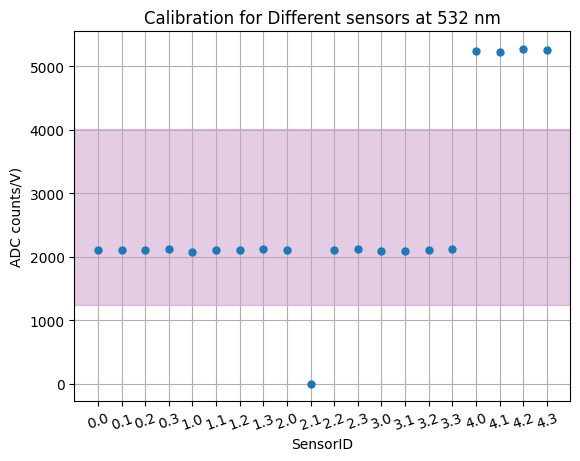

In [88]:
# Customize the plot
fig = plt.figure(100)
plt.errorbar(range(len(slopes)), slopes,stderr, fmt='.', markersize=10, linewidth=1)
plt.title(f'Calibration for Different sensors at {wavelength} nm')
plt.xlabel('SensorID')
plt.ylabel('ADC counts/V)')
#plt.xticks(range(len(slopes)), [f'{i+1}' for i in range(len(sensorsID))])  # Label the x-axis with dataset identifiers
plt.xticks(np.arange(len(slopes)), sensorsID, rotation=20)
#plt.legend()
#plt.axhline(y=res.slope, color='red', linestyle='--', label='Horizontal Line at y=m_all')
#plt.axhline(y=np.mean(slopes), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
#plt.fill_between(range(-1,len(slopes)+1), (res.slope-res.stderr), (res.slope+res.stderr), color='red', alpha=0.3, label='Shaded Region')
plt.fill_between(range(-1,len(slopes)+1), (np.mean(slopes)-np.std(slopes)), (np.mean(slopes)+np.std(slopes)), color='purple', alpha=0.2, label='Shaded Region')
#plt.ylim([0.00064, 0.000665])
plt.xlim([-1,len(sensorsID)])
plt.grid()
# Show the plot
plt.savefig(f'{outputpath}/test23052024_{wavelength}_calibration_{datasets}.png',dpi=199)  # Display the current figure
#plt.show()
#plt.tight_layout()


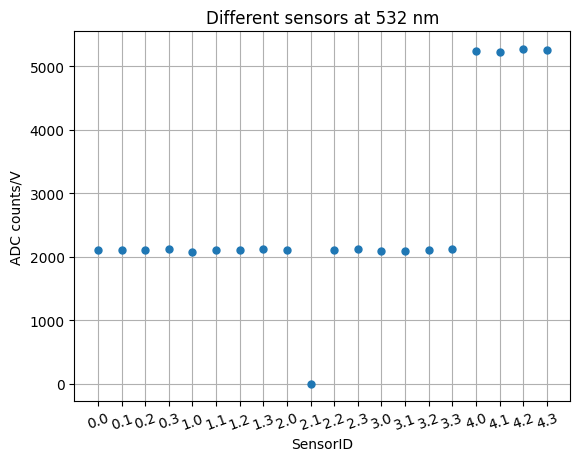

In [89]:
# Customize the plot
fig = plt.figure(100)
plt.errorbar(range(len(slopes)), slopes,stderr, fmt='.', markersize=10, linewidth=1)
plt.title(f'Different sensors at {wavelength} nm')
plt.xlabel('SensorID')
plt.ylabel('ADC counts/V')
#plt.xticks(range(len(slopes)), [f'{i+1}' for i in range(len(sensorsID))])  # Label the x-axis with dataset identifiers
plt.xticks(np.arange(len(slopes)), sensorsID, rotation=20)
#plt.legend()
#plt.axhline(y=res.slope, color='red', linestyle='--', label='Horizontal Line at y=m_all')
#plt.axhline(y=np.mean(slopes[9:]), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
#plt.fill_between(range(-1,len(slopes)+1), (res.slope-res.stderr), (res.slope+res.stderr), color='red', alpha=0.3, label='Shaded Region')
#plt.fill_between(range(-1,len(slopes)+1), (np.mean(slopes)-np.std(slopes)), (np.mean(slopes)+np.std(slopes)), color='purple', alpha=0.2, label='Shaded Region')
#plt.ylim([0.00064, 0.000665])
plt.xlim([-1,len(sensorsID)])
plt.grid()
# Show the plot
plt.savefig(f'{outputpath}/test23052024_{wavelength}_noshades_calibration_{datasets}.png',dpi=199)  # Display the current figure
#plt.show()
#plt.tight_layout()

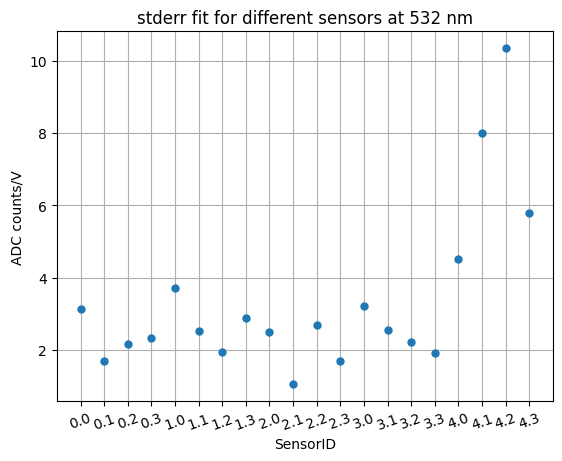

In [90]:
# Customize the plot
fig = plt.figure(200)
plt.errorbar(range(len(stderr)), stderr, fmt='.', markersize=10, linewidth=1)
plt.title(f'stderr fit for different sensors at {wavelength} nm')
plt.xlabel('SensorID')
plt.ylabel('ADC counts/V')
#plt.xticks(range(len(slopes)), [f'{i+1}' for i in range(len(sensorsID))])  # Label the x-axis with dataset identifiers
plt.xticks(np.arange(len(stderr)), sensorsID, rotation=20)
#plt.legend()
#plt.axhline(y=res.slope, color='red', linestyle='--', label='Horizontal Line at y=m_all')
#plt.axhline(y=np.mean(slopes), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
#plt.fill_between(range(-1,len(slopes)+1), (res.slope-res.stderr), (res.slope+res.stderr), color='red', alpha=0.3, label='Shaded Region')
#plt.fill_between(range(-1,len(slopes)+1), (np.mean(slopes)-np.std(slopes)), (np.mean(slopes)+np.std(slopes)), color='purple', alpha=0.2, label='Shaded Region')
#plt.ylim([0.00064, 0.000665])
plt.xlim([-1,len(sensorsID)])
plt.grid()
# Show the plot
plt.savefig(f'{outputpath}/test23052024_{wavelength}_noshades_stderrs_{datasets}.png',dpi=199)  # Display the current figure
#plt.show()
#plt.tight_layout()

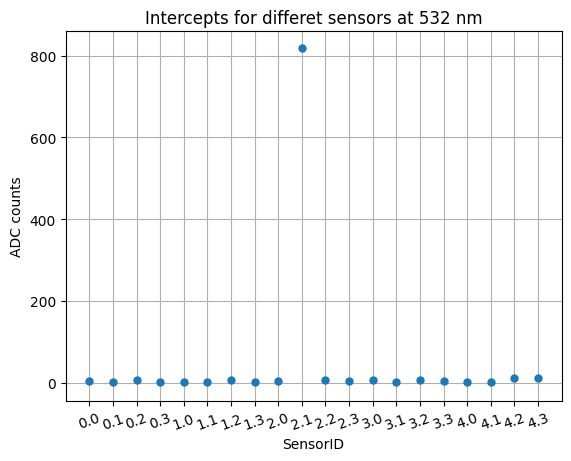

In [91]:
fig = plt.figure(300)
plt.errorbar(range(len(intercepts)), intercepts,intercepts_stderr, fmt='.', markersize=10, linewidth=1)
plt.title(f'Intercepts for differet sensors at {wavelength} nm')
plt.xlabel('SensorID')
plt.ylabel('ADC counts')
#plt.xticks(range(len(slopes)), [f'{i+1}' for i in range(len(sensorsID))])  # Label the x-axis with dataset identifiers
plt.xticks(np.arange(len(intercepts)), sensorsID, rotation=20)
#plt.legend()
#plt.axhline(y=res.slope, color='red', linestyle='--', label='Horizontal Line at y=m_all')
#plt.axhline(y=np.mean(slopes), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
#plt.fill_between(range(-1,len(slopes)+1), (res.slope-res.stderr), (res.slope+res.stderr), color='red', alpha=0.3, label='Shaded Region')
#plt.fill_between(range(-1,len(slopes)+1), (np.mean(slopes)-np.std(slopes)), (np.mean(slopes)+np.std(slopes)), color='purple', alpha=0.2, label='Shaded Region')
#plt.ylim([0.00064, 0.000665])
plt.xlim([-1,len(sensorsID)])
plt.grid()
# Show the plot
plt.savefig(f'{outputpath}/test23052024_{wavelength}_noshade_intercepts_{datasets}.png',dpi=199)  # Display the current figure
#plt.show()
#plt.tight_layout()

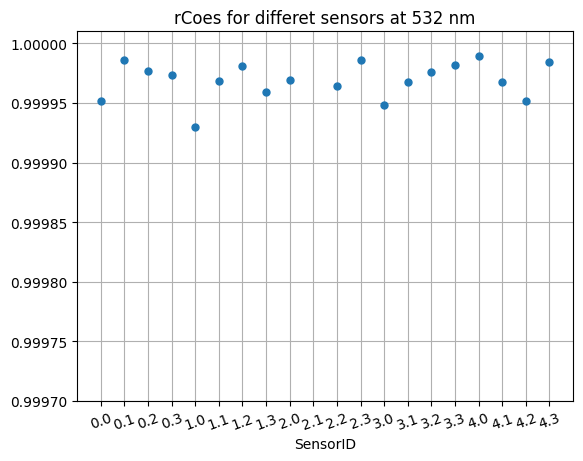

In [92]:
fig = plt.figure(400)
plt.errorbar(range(len(rCoes)), rCoes, fmt='.', markersize=10, linewidth=1)
plt.title(f'rCoes for differet sensors at {wavelength} nm')
plt.xlabel('SensorID')
plt.ylabel('')
#plt.xticks(range(len(slopes)), [f'{i+1}' for i in range(len(sensorsID))])  # Label the x-axis with dataset identifiers
plt.xticks(np.arange(len(rCoes)), sensorsID, rotation=20)
#plt.legend()
#plt.axhline(y=res.slope, color='red', linestyle='--', label='Horizontal Line at y=m_all')
#plt.axhline(y=np.mean(slopes), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
#plt.fill_between(range(-1,len(slopes)+1), (res.slope-res.stderr), (res.slope+res.stderr), color='red', alpha=0.3, label='Shaded Region')
#plt.fill_between(range(-1,len(slopes)+1), (np.mean(slopes)-np.std(slopes)), (np.mean(slopes)+np.std(slopes)), color='purple', alpha=0.2, label='Shaded Region')
plt.ylim([0.9997, 1.00001])
#plt.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.xlim([-1,len(sensorsID)])
plt.grid()
# Show the plot
plt.savefig(f'{outputpath}/test23052024_{wavelength}_noshade_rcoes_{datasets}.png',dpi=199)  # Display the current figure
#plt.show()
#plt.tight_layout()